In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import joblib

In [7]:
# Paths to the dataset
TRAIN_DIR = r"C:\Users\ARUN KUMAR\Downloads\archive (2)\chest_xray\train"
TEST_DIR = r"C:\Users\ARUN KUMAR\Downloads\archive (2)\chest_xray\test"

In [8]:
# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Data Preprocessing
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img

In [9]:
def load_data(directory):
    labels = []
    images = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(directory, label)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(0 if label == 'NORMAL' else 1)
    return np.array(images), np.array(labels)

# Load and preprocess the data
train_images, train_labels = load_data(TRAIN_DIR)
test_images, test_labels = load_data(TEST_DIR)

In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

In [11]:
# Build ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Extract features
def extract_features(images):
    features = model.predict(images)
    return features

train_features = extract_features(train_images)
test_features = extract_features(test_images)

163/163 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


In [12]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [13]:
# Save the trained model
joblib.dump(rf_classifier, 'rf_pneumonia_model.pkl')
joblib.dump(model, 'resnet50_model.h5')

# Predict on test data
test_predictions = rf_classifier.predict(test_features)
# Evaluate the model
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(test_labels, test_predictions))

Accuracy: 80.13%
              precision    recall  f1-score   support

           0       0.94      0.50      0.65       234
           1       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



In [14]:
# Function to predict pneumonia on a new image
def predict_pneumonia(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    feature = model.predict(img)
    prediction = rf_classifier.predict(feature)
    return 'PNEUMONIA' if prediction == 1 else 'NORMAL'

# Test with an unseen image
unseen_image_path = r"C:\Users\ARUN KUMAR\Downloads\archive (2)\chest_xray\chest_xray\val\NORMAL\NORMAL2-IM-1440-0001.jpeg"
result = predict_pneumonia(unseen_image_path)
print(f'The prediction for the unseen image is: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
The prediction for the unseen image is: NORMAL


Accuracy: 80.13%
Precision: 76.60%
Recall: 98.21%
F1 Score: 86.07%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.50      0.65       234
           1       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



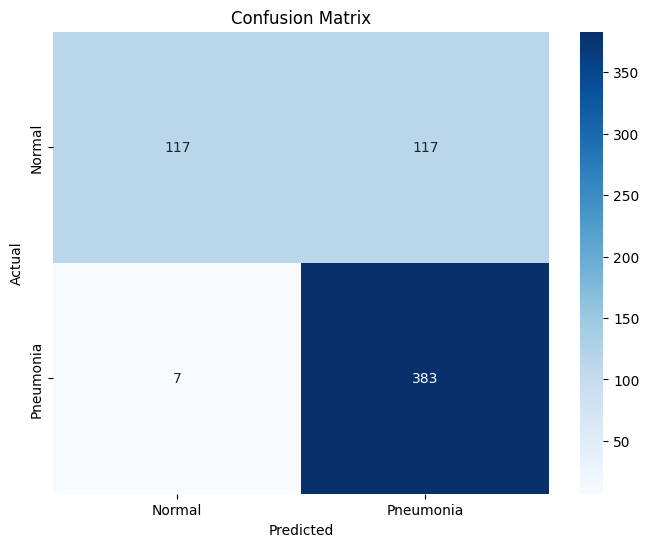

In [15]:
# Evaluate the model
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print('\nClassification Report:\n', classification_report(test_labels, test_predictions))

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()